In [7]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [8]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split("source_transcript=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get CHM gene_ids
        df["CHM_gene_id"] = df["other"].str.split("gene_id=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["CHM_transcript_id"] = df["other"].str.split("transcript_id=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get transcript names
        df["transcript_name"] = df["other"].str.split("source_transcript_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get start codon
        df["start_codon"] = df["other"].str.split("adj_start=", expand=True)[1].str.split(";", expand=True)[0]
        
        ## Get stop codon
        df["stop_codon"] = df["other"].str.split("adj_stop=", expand=True)[1].str.split(";", expand=True)[0]        

        ## Only keep relevant
        df = df[["chr", "start", "end", "strand", "type", "gene_id", "transcript_id", "CHM_gene_id",
                 "CHM_transcript_id", "transcript_name", "gene_name", "start_codon", "stop_codon"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get CHM transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Label novel transcripts
        df.loc[df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
        df.loc[~df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

        ## Label novel genes
        df.loc[df["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
        df.loc[~df["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [9]:
'''
function name: merge_annotations

purpose: Merge useful/relevant information from both annotations while removing repeated and irrelevant information

input: Two different GTF annotations

output: One GTF annotation containing all the relevant information
'''

def merge_annotations(ref_gtf, bambu_gtf):
    
    ## Merge the two annotations
    names_ref_gtf = ref_gtf[["transcript_id", "gene_id", "gene_name", "transcript_name"]].copy()
    merged_gtf = pd.merge(bambu_gtf, names_ref_gtf, on=['gene_id', 'transcript_id'], how='left')
    merged_gtf.drop_duplicates(inplace=True)

    ## Label novel transcripts
    merged_gtf.loc[merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
    merged_gtf.loc[~merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

    ## Label novel genes
    merged_gtf.loc[merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
    merged_gtf.loc[~merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

    ## Create temporary variable only containing novel transcripts
    temp = merged_gtf.loc[merged_gtf["is_novel_transcript"] == True]

    ## Annotate novel transcripts
    merged_tmp = pd.merge(temp, ref_gtf[["gene_id", "gene_name"]], on=['gene_id'], how='left')
    merged_tmp.drop_duplicates(inplace=True)
    merged_tmp["gene_name"] = merged_tmp["gene_name_y"]
    merged_tmp.drop(columns=["source", "gene_name_y", "gene_name_x"], inplace=True)

    ## Return novel transcripts to original annotation
    merged_final = pd.merge(merged_gtf, merged_tmp, on=['chr', 'type', 'start', 'end', 'strand', 'transcript_id',
                    'transcript_name', 'gene_id', 'is_novel_transcript', 'is_novel_gene', 'exon_number'], how="left")

    ## Get gene names for novel transcripts of known genes
    merged_final.gene_name_x.fillna(merged_final.gene_name_y, inplace=True)
    merged_final["gene_name"] = merged_final["gene_name_x"]
    merged_final.drop(columns =["gene_name_x", "gene_name_y"], inplace=True)
    
    ## Get start and stop codons for known transcripts and exons of protein coding genes
    ref_gtf = ref_gtf[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "start_codon", "stop_codon"]]
    merged_final = pd.merge(merged_final, ref_gtf, on=["chr", "type", "start", "end", "strand", "transcript_id", "gene_id"], how="left")
    
    
    merged_final = merged_final[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "gene_name", 
                    "exon_number", "transcript_name", "start_codon", "stop_codon", "is_novel_gene", "is_novel_transcript"]]


    
    return merged_final 

In [10]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

In [11]:
chm13_counts = pd.read_csv("../../data/novel_genes/chm13_bambu/counts_transcript.txt", delimiter="\t", low_memory=False, 
                           header=0,)
grch_counts = pd.read_csv("../../data/novel_genes/GRCh38_bambu/counts_transcript.txt", delimiter="\t", low_memory=False, 
                           header=0,)

list_counts = [chm13_counts, grch_counts]

for df in list_counts:
    
    new_col_names = []
    
    for col in df.columns:
        new_col_names.append(col.split("_nanopore")[0])
        
    df.columns = new_col_names

In [12]:
chm13_counts.columns

Index(['TXNAME', 'GENEID', 'sample_PAM54902', 'sample_PAM54401',
       'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814'],
      dtype='object')

In [13]:
print("CHM13 counts per sample:\n")
print(chm13_counts[['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']].sum())

print("\n GRCH38 counts per sample:\n")
print(grch_counts[['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']].sum())

print("\nDifference in Counts per Sample:\n")
difference = chm13_counts[['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']].sum() - grch_counts[['sample_421', 'sample_20484', 'sample_27527', 'sample_356', 'sample_20814']].sum()
print(difference)

print("\nPercent difference in Counte per Sample:\n")
percent_difference = difference/(chm13_counts[['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']].sum())
print(percent_difference * 100)


CHM13 counts per sample:

sample_PAM54902    3.194615e+07
sample_PAM54401    3.739172e+07
sample_PAM54335    2.695662e+07
sample_PAM54788    4.773581e+07
sample_PAK20814    3.806709e+07
dtype: float64

 GRCH38 counts per sample:



KeyError: "None of [Index(['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335',\n       'sample_PAM54788', 'sample_PAK20814'],\n      dtype='object')] are in the [columns]"

In [14]:
## Find novel transcripts in both annotations
chm13_counts.loc[chm13_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = True
chm13_counts.loc[~chm13_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = False

grch_counts.loc[grch_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = True
grch_counts.loc[~grch_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = False

## Find novel genes in both annotations
chm13_counts.loc[chm13_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = True
chm13_counts.loc[~chm13_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = False

grch_counts.loc[grch_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = True
grch_counts.loc[~grch_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = False

In [15]:
exclusive_chm13 = pd.read_csv("../../data/novel_genes/CHM13_novel_genes_isoseq.csv")

In [16]:
exclusive_chm13.head()

,GENEID
0,CHM13_G0002360
1,CHM13_G0002906
2,CHM13_G0003812
3,CHM13_G0006285
4,CHM13_G0007830


In [17]:
chm13_exclusive = chm13_counts.loc[chm13_counts["GENEID"].isin(exclusive_chm13["GENEID"])].copy()

In [18]:
chm13_exclusive.shape

(57, 9)

In [19]:
## Filter novel genes and transcripts, must be present in every sample with 5+ counts.
count_cols = ['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']

for col in count_cols:
    chm13_exclusive = chm13_exclusive.loc[chm13_exclusive[col] > 5].copy()

In [20]:
chm13_exclusive.shape

(13, 9)

In [21]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
chm13_novel_genes = chm13_counts.loc[chm13_counts["is_novel_gene"]]
grch_novel_genes = grch_counts.loc[grch_counts["is_novel_gene"]]

chm13_novel_transcripts = chm13_counts.loc[((chm13_counts["is_novel_transcript"]) & (~chm13_counts["is_novel_gene"]))]
grch_novel_transcripts = grch_counts.loc[((grch_counts["is_novel_transcript"]) & (~grch_counts["is_novel_gene"]))]

In [22]:
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13")

print("We found", grch_novel_genes.shape[0], "novel genes in GRCh38")

We found 212 novel genes in CHM13
We found 160 novel genes in GRCh38


In [23]:
## Filter novel genes and transcripts, must be present in every sample with 5+ counts.
count_cols = ['sample_PAM54902', 'sample_PAM54401', 'sample_PAM54335', 'sample_PAM54788', 'sample_PAK20814']

for col in count_cols:
    chm13_novel_genes = chm13_novel_genes.loc[chm13_novel_genes[col] > 5]
    #grch_novel_genes = grch_novel_genes.loc[grch_novel_genes[col] > 5]
    chm13_novel_transcripts = chm13_novel_transcripts.loc[chm13_novel_transcripts[col] > 5]
    #grch_novel_transcripts = grch_novel_transcripts.loc[grch_novel_transcripts[col] > 5]

In [24]:
## Count number of novel genes and novel transcripts in each dataframe
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13")
print("We found", grch_novel_genes.shape[0], "novel genes in GRCh38")

print("We found", chm13_novel_transcripts.shape[0], "novel transcripts of known genes in CHM13")
print("We found", grch_novel_transcripts.shape[0], "novel transcripts of known genes in GRCh38")

We found 146 novel genes in CHM13
We found 160 novel genes in GRCh38
We found 428 novel transcripts of known genes in CHM13
We found 270 novel transcripts of known genes in GRCh38


In [25]:
chm13_novel_genes["GENEID"].value_counts()

gene.989     4
gene.746     2
gene.379     2
gene.892     2
gene.222     2
gene.292     2
gene.72      2
gene.358     2
gene.676     2
gene.718     2
gene.42      2
gene.178     2
gene.570     2
gene.553     2
gene.197     2
gene.536     2
gene.635     1
gene.1015    1
gene.879     1
gene.237     1
gene.13      1
gene.651     1
gene.955     1
gene.468     1
gene.755     1
gene.520     1
gene.351     1
gene.195     1
gene.806     1
gene.855     1
gene.1013    1
gene.514     1
gene.752     1
gene.136     1
gene.941     1
gene.683     1
gene.550     1
gene.959     1
gene.306     1
gene.244     1
gene.480     1
gene.997     1
gene.895     1
gene.668     1
gene.603     1
gene.22      1
gene.453     1
gene.185     1
gene.332     1
gene.788     1
gene.367     1
gene.748     1
gene.679     1
gene.967     1
gene.316     1
gene.428     1
gene.818     1
gene.501     1
gene.470     1
gene.802     1
gene.987     1
gene.915     1
gene.51      1
gene.17      1
gene.392     1
gene.647     1
gene.950  

In [26]:
chm13_novel_genes.loc[chm13_novel_genes["GENEID"] == "gene.989"]

,TXNAME,GENEID,sample_PAM54902,sample_PAM54401,sample_PAM54335,sample_PAM54788,sample_PAK20814,is_novel_transcript,is_novel_gene
651,tx.652,gene.989,653.065333,2424.468517,1571.293188,1356.549767,3210.254654,True,True
652,tx.653,gene.989,444.249361,1717.037009,830.732977,949.355434,2446.676183,True,True
653,tx.654,gene.989,250.205703,791.827812,391.937493,537.436985,1210.517097,True,True
654,tx.655,gene.989,208.479603,1758.666662,726.036342,967.657814,2644.552066,True,True


In [30]:
## Open extended annotations and parse through them
chm13_ref = pd.read_csv("../../data/novel_genes//chm13_bambu/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
grch_ref = pd.read_csv("../../data/novel_genes/GRCh38_bambu/extended_annotations.gtf", header=None, delimiter="\t",
                       low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

chm13_ref = parse_df_columns(chm13_ref, is_ref=False)
grch_ref = parse_df_columns(grch_ref, is_ref=False)

In [31]:
## Fix up extended annotations to merge with counts matrices
chm13_ref.columns = ['chr', 'source', 'type', 'start', 'end', 'strand', 'GENEID', 
                     'TXNAME', 'exon_number', 'is_novel_transcript', 'is_novel_gene']
chm13_ref = chm13_ref.loc[chm13_ref["type"] == "transcript"].copy()
chm13_ref = chm13_ref[["chr", "start", "end", "GENEID", "TXNAME"]]

grch_ref.columns = ['chr', 'source', 'type', 'start', 'end', 'strand', 'GENEID', 
                     'TXNAME', 'exon_number', 'is_novel_transcript', 'is_novel_gene']
grch_ref = grch_ref.loc[grch_ref["type"] == "transcript"].copy()
grch_ref = grch_ref[["chr", "start", "end", "GENEID", "TXNAME"]]

In [32]:
## Create gene location extractor for novel genes in both dataframes
chm13_extractor = pd.merge(chm13_novel_genes[["GENEID", "TXNAME"]], chm13_ref, how="left", on=["GENEID", "TXNAME"])
grch_extractor = pd.merge(grch_novel_genes[["GENEID", "TXNAME"]], grch_ref, how="left", on=["GENEID", "TXNAME"])

In [33]:
## Create extraction column and drop others
chm13_extractor[["start", "end"]] = chm13_extractor[["start", "end"]].astype("int")
grch_extractor[["start", "end"]] = grch_extractor[["start", "end"]].astype("int")


chm13_extractor[["chr", "start", "end", "GENEID", "TXNAME"]] = chm13_extractor[["chr", "start", "end", "GENEID", "TXNAME"]].astype("str")
grch_extractor[["chr", "start", "end", "GENEID", "TXNAME"]] = grch_extractor[["chr", "start", "end", "GENEID", "TXNAME"]].astype("str")


chm13_extractor["extraction"] = chm13_extractor["chr"] + ":" + chm13_extractor["start"] + "-" + chm13_extractor["end"]
grch_extractor["extraction"] = grch_extractor["chr"] + ":" + grch_extractor["start"] + "-" + grch_extractor["end"]

chm13_extractor = chm13_extractor[["GENEID", "TXNAME", "extraction"]].copy()
grch_extractor = grch_extractor[["GENEID", "TXNAME", "extraction"]].copy()

In [34]:
## Save novel gene sequence extractors for samtools
chm13_extractor.to_csv("chm13_novel_gene_extractor.txt", sep="\t", index=False, header=False)
grch_extractor.to_csv("grch_novel_gene_extractor.txt", sep="\t", index=False, header=False)

Text(0.5, 1.0, 'Genes with Novel Transcripts')

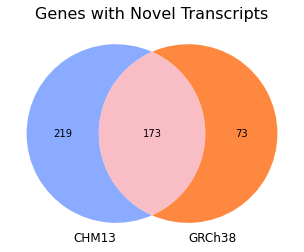

In [35]:
## Make venn diagram for genes expressing novel isoforms.

chm13_novel_transcripts["GENEID"] = chm13_novel_transcripts["GENEID"].str.split(".", expand=True)[0]

chm13_set = chm13_novel_transcripts["GENEID"]
grch_set = grch_novel_transcripts["GENEID"]

venn2_unweighted(subsets = [set(chm13_set), set(grch_set)], set_labels = ('CHM13', 'GRCh38'), 
                 set_colors=('#648FFF', '#FE6100'), alpha = 0.75);

plt.title("Genes with Novel Transcripts", size=16)

In [37]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
chm13_ref = pd.read_csv("../../data/novel_genes/chm13_bambu/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


chm13_ref = parse_df_columns(chm13_ref, is_ref=False)

In [38]:
chm13_ref.head()

,chr,source,type,start,end,strand,gene_id,transcript_id,exon_number,is_novel_transcript,is_novel_gene
0,chr1,Bambu,transcript,11136.0,12457.0,-,ENSG00000239945.1(LOFF_G0000001),ENST00000495576.1(LOFF_T0000001),NaN,False,False
1,chr1,Bambu,exon,11136.0,11635.0,-,ENSG00000239945.1(LOFF_G0000001),ENST00000495576.1(LOFF_T0000001),2,False,False
2,chr1,Bambu,transcript,11630.0,13433.0,+,ENSG00000286448.1(LOFF_G0000002),ENST00000669836.1(LOFF_T0000002),NaN,False,False
3,chr1,Bambu,exon,11630.0,11831.0,+,ENSG00000286448.1(LOFF_G0000002),ENST00000669836.1(LOFF_T0000002),1,False,False
4,chr1,Bambu,exon,11639.0,12457.0,-,ENSG00000239945.1(LOFF_G0000001),ENST00000495576.1(LOFF_T0000001),1,False,False


In [39]:
chm13_ref["gene_id"] = chm13_ref["gene_id"].str.split(".", expand=True)

In [40]:
chm13_ref = chm13_ref.loc[chm13_ref["type"] == "transcript"]

In [41]:
chm13_novel_transcripts_expressed = chm13_ref.loc[chm13_ref["transcript_id"].isin(chm13_novel_transcripts["TXNAME"])].copy()

In [57]:
disease_relevant_genes = pd.read_csv("../../../cDNA-comparison/article_analysis/annotations/disease_relevant_gene_names.csv", names=["gene_id", "gene_name"],
                                    header=0)

## Create list of novel transcripts in disease relevant genes
novel_relevant = pd.merge(disease_relevant_genes, chm13_novel_transcripts_expressed, how='inner', on="gene_id")

In [58]:
novel_relevant.head()

,gene_id,gene_name,chr,source,type,start,end,strand,transcript_id,exon_number,is_novel_transcript,is_novel_gene
0,ENSG00000027847,B4GALT7,chr5,Bambu,transcript,178142421.0,178147501.0,+,tx.230,NaN,True,False
1,ENSG00000054282,SDCCAG8,chr1,Bambu,transcript,242667072.0,242717514.0,+,tx.63,NaN,True,False
2,ENSG00000067225,PKM,chr15,Bambu,transcript,70015757.0,70047905.0,-,tx.497,NaN,True,False
3,ENSG00000070501,POLB,chr8,Bambu,transcript,42608550.0,42642104.0,+,tx.316,NaN,True,False
4,ENSG00000091592,NLRP1,chr17,Bambu,transcript,5393165.0,5394285.0,-,tx.531,NaN,True,False


In [59]:
neuro_disease = pd.read_csv("../../data/novel_genes/psych_neuro_relevant_genes_list_bah_2021-09-07.csv")

In [60]:
neuro_disease = neuro_disease["Gene Name"]

In [61]:
neuro_disease_expressed.head()

NameError: name 'neuro_disease_expressed' is not defined

In [64]:
neuro_disease_expressed = novel_relevant.loc[novel_relevant["gene_name"].isin(neuro_disease)]

In [65]:
neuro_disease_expressed.head()

,gene_id,gene_name,chr,source,type,start,end,strand,transcript_id,exon_number,is_novel_transcript,is_novel_gene
4,ENSG00000091592,NLRP1,chr17,Bambu,transcript,5393165.0,5394285.0,-,tx.531,NaN,True,False
8,ENSG00000114956,DGUOK,chr2,Bambu,transcript,73935343.0,73967416.0,+,tx.91,NaN,True,False
28,ENSG00000165092,ALDH1A1,chr9,Bambu,transcript,85051589.0,85231348.0,-,tx.349,NaN,True,False


In [45]:
novel_relevant.drop(columns=["gene_id", "gene_name"], inplace=True)

In [46]:
novel_relevant.shape

(44, 10)

In [47]:
novel_relevant.to_csv("../../data/novel_genes/novel_med_relevant_transcript_annotation_chm13.gtf", 
                                        sep="\t", header=False, index=False)

In [14]:
chm13_ref = pd.read_csv("../novel_gene_body_raw_data/chm13_bambu/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

In [15]:
chm13_ref.head()

,chr,source,type,start,end,dot_1,strand,dot_2,other
0,chr1,Bambu,transcript,11136,12457,.,-,.,"gene_id ""ENSG00000239945.1(LOFF_G0000001)""; tr..."
1,chr1,Bambu,exon,11136,11635,.,-,.,"gene_id ""ENSG00000239945.1(LOFF_G0000001)""; tr..."
2,chr1,Bambu,transcript,11630,13433,.,+,.,"gene_id ""ENSG00000286448.1(LOFF_G0000002)""; tr..."
3,chr1,Bambu,exon,11630,11831,.,+,.,"gene_id ""ENSG00000286448.1(LOFF_G0000002)""; tr..."
4,chr1,Bambu,exon,11639,12457,.,-,.,"gene_id ""ENSG00000239945.1(LOFF_G0000001)""; tr..."


In [23]:
chm13_ref = chm13_ref.loc[chm13_ref["type"] == "transcript"]

In [31]:
chm13_ref.loc[chm13_ref["is_novel_gene"] == True]

,chr,source,type,start,end,strand,gene_id,transcript_id,exon_number,is_novel_transcript,is_novel_gene
17202,chr1,Bambu,transcript,16245735.0,16247595.0,-,gene.51,tx.2,NaN,True,True
26029,chr1,Bambu,transcript,26268774.0,26270140.0,-,gene.64,tx.6,NaN,True,True
27377,chr1,Bambu,transcript,27231889.0,27233743.0,-,gene.66,tx.7,NaN,True,True
29806,chr1,Bambu,transcript,29948153.0,29953421.0,-,gene.68,tx.10,NaN,True,True
30273,chr1,Bambu,transcript,31007199.0,31007976.0,+,gene.5,tx.11,NaN,True,True
36935,chr1,Bambu,transcript,38167408.0,38300289.0,-,gene.72,tx.12,NaN,True,True
36936,chr1,Bambu,transcript,38167408.0,38300320.0,-,gene.72,tx.13,NaN,True,True
61708,chr1,Bambu,transcript,68243853.0,68261649.0,-,gene.76,tx.22,NaN,True,True
64998,chr1,Bambu,transcript,77862296.0,77863997.0,+,gene.13,tx.23,NaN,True,True
85157,chr1,Bambu,transcript,120334901.0,120336836.0,+,gene.17,tx.26,NaN,True,True
